 <font size="6"> __Build and evaluate a CNN for detecting dinosaurs__ </font>

# Import relevant modules/functions

In [24]:
# Basics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import os
import warnings
warnings.filterwarnings("ignore")

# Tensorflow 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import backend as K, models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras import preprocessing 

# Scikeras
from scikeras.wrappers import KerasClassifier

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [25]:
# Logging to see whether CPU or GPU is doing the current task
# from tensorflow import debugging
# debugging.set_log_device_placement(True)

# Import images and train-test-split

_Data has been created via own webcam and needs to be loaded into notebook_

In [26]:
%ls ../images/dinosaurs

brachiosaurus/ hand_only/     t-rex/
empty/         stegosaurus/   triceratops/


In [27]:
X = []
y = []
classes = []
base_path = '../images/dinosaurs'

for i, target in enumerate(os.listdir(base_path)):
    if re.findall(pattern=r'^[^.]', string=target):
        classes.append(target)
        files = os.listdir(base_path+'/'+target)
        for file in files:
            if re.findall(pattern=r'^\d+', string=file):
                # load the image
                img = load_img(base_path+'/'+target+'/'+file)
                # convert it to an array
                img_array = np.array(img)
                # append the array to X
                X.append(img_array)
                # append the numeric target to y
                y.append(len(classes)-1)

X = np.array(X)
y = np.array(y)

# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]

In [28]:
# Check the shape
X.shape, y.shape

((900, 224, 224, 3), (900,))

In [29]:
# Show the different classes
classes

['empty', 'triceratops', 'stegosaurus', 'hand_only', 't-rex', 'brachiosaurus']

In [30]:
# Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
# Check shapes
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((720, 224, 224, 3), (720,), (180, 224, 224, 3), (180,))

'empty'

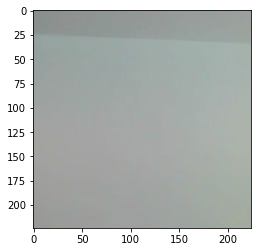

In [32]:
int_rnd = np.random.randint(100)
plt.imshow(X_train[int_rnd]); classes[y_train[int_rnd]]

In [33]:
# One hot encoding of y-labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Build CNN from scratch

## Create CNN

In [11]:
# Build model:
def create_cnn(network):
    """
    This function creates a Convolutional Neural Network (CNN) based o a predefined network structure.
    This approach is chosen to be able to later conduct parameter analysis via grid search.
    """
    # Create initial model
    model = Sequential()
    
    # Add layers
    first_dense = True
    for i, layer in enumerate(network):
    
        # Add convolutional layers
        if layer[0] == "Conv2D":
            layer_type, filters, kernel_size, padding = layer
        
            # Add first convolutional layer with input shape
            if i == 0:
                model.add(Conv2D(filters=filters, kernel_size=kernel_size, 
                             strides=(1,1), padding=padding, activation="relu", 
                             input_shape=(224,224,3)))

            # Add more convolutional layers
            else:
                model.add(Conv2D(filters=filters, kernel_size=kernel_size, 
                                 strides=(1,1), padding=padding, activation="relu"))
            
            # Add pooling to conv. layer
            model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2),padding=padding))

        # Add dense layers
        elif layer[0] == "Dense":
            layer_type, n_dense_units = layer
            
            #Add flatten layer before first dense layer
            if first_dense:
                model.add(Flatten())
                first_dense = False
            
            # Actual dense layer
            model.add(Dropout(0.2))
            model.add(Dense(n_dense_units, activation='relu'))

    ### Output layer (6 classes) ###
    model.add(Dense(6 ,activation= "softmax"))
    
    return model

In [12]:
# Let's define a base model - important more Cvn2D-layers reduce the parameters at the beginning! 
base_model = [
    ['Conv2D', 16, (3,3), 'valid'],
    ['Conv2D', 32, (3,3), 'valid'],
    ['Conv2D', 64, (3,3), 'valid'],
    ['Dense', 50],
]

create_cnn(base_model).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [13]:
# Implement early stopping for fitting and grid search based on validation loss
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    min_delta=0.001, 
    patience=5, 
    verbose=1, 
    mode='auto',
    restore_best_weights = True,
)

In [14]:
# Define KerasClassifier
scikeras_cnn = KerasClassifier(build_fn=create_cnn,
                               network=base_model,
                               optimizer='Adam',
                               loss='categorical_crossentropy',
                               metrics=['accuracy'],
                               batch_size=1000,
                               epochs=50,
                               verbose=1,
                               validation_split=0.2,
                               callbacks=[early_stop],
                              )

In [15]:
# Clear session (backend)
K.clear_session()

In [16]:
# Fit the model
scikeras_cnn.fit(X_train, y_train)

Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 21.9476 - accuracy: 0.1685 - val_loss: 127.9519 - val_accuracy: 0.1778
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 141.7102 - accuracy: 0.1685 - val_loss: 210.3248 - val_accuracy: 0.1778
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: 213.7138 - accuracy: 0.1815 - val_loss: 86.0071 - val_accuracy: 0.1556
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 91.9198 - accuracy: 0.1833 - val_loss: 48.5647 - val_accuracy: 0.1778
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 53.5457 - accuracy: 0.1444 - val_loss: 25.3445 - val_accuracy: 0.2074
Epoch 6/50
1/1 [==============================] - 4s 4s/step - loss: 28.4088 - accuracy: 0.1852 - val_loss: 13.7717 - val_accuracy: 0.4296
Epoch 7/50
1/1 [==============================] - 4s 4s/step - loss: 15.3372 - accuracy: 0.4074 - val_loss: 7.6534 - val_accuracy: 0.4519
Epoch 8/50
1/1 [========

KerasClassifier(
	model=None
	build_fn=<function create_cnn at 0x12f99e5e0>
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=categorical_crossentropy
	metrics=['accuracy']
	batch_size=1000
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x15f1062e0>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=50
	network=[['Conv2D', 16, (3, 3), 'valid'], ['Conv2D', 32, (3, 3), 'valid'], ['Conv2D', 64, (3, 3), 'valid'], ['Dense', 50]]
	class_weight=None
)

In [17]:
# Show score for train and test data
scikeras_cnn.score(X_train, y_train), scikeras_cnn.score(X_test, y_test)

1/1 [==============================] - 0s 66ms/step


(0.9437037037037037, 0.8933333333333333)

In [18]:
# Show keys for history dict
scikeras_cnn.history_.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

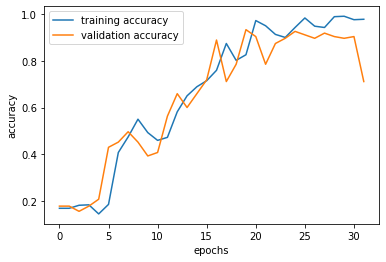

In [19]:
# Plot accuracy curve
plt.plot(scikeras_cnn.history_['accuracy'], label='training accuracy')
plt.plot(scikeras_cnn.history_['val_accuracy'], label= 'validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

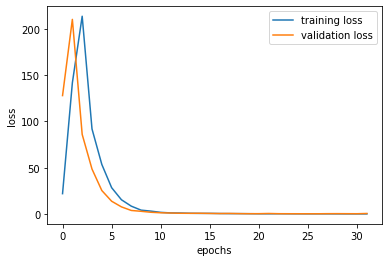

In [20]:
# Plot loss
plt.plot(scikeras_cnn.history_['loss'], label='training loss')
plt.plot(scikeras_cnn.history_['val_loss'], label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

##  Optimize via grid search

In [21]:
# Define models to compare

wider_kernel = [
    ['Conv2D', 16, (5,5), 'valid'],
    ['Conv2D', 32, (5,5), 'valid'],
    ['Conv2D', 64, (5,5), 'valid'],
    ['Dense', 50],
]

zero_padding = [
    ['Conv2D', 16, (3,3), 'same'],
    ['Conv2D', 32, (3,3), 'same'],
    ['Conv2D', 64, (3,3), 'same'],
    ['Dense', 50],
]

more_filters = [
    ['Conv2D', 32, (3,3), 'valid'],
    ['Conv2D', 64, (3,3), 'valid'],
    ['Conv2D', 128, (3,3), 'valid'],
    ['Dense', 50],
]

more_layers = [
    ['Conv2D', 16, (3,3), 'valid'],
    ['Conv2D', 32, (3,3), 'valid'],
    ['Conv2D', 64, (3,3), 'valid'],
    ['Conv2D', 64, (3,3), 'valid'],
    ['Dense', 50],
    ['Dense', 50],
]

network_grid_search = {
    'network': [base_model, wider_kernel, zero_padding, more_filters, more_layers]
}

In [22]:
#create_cnn(more_layers).summary()

In [23]:
# Conduct grid search
grid_cnn = GridSearchCV(scikeras_cnn, network_grid_search, scoring='accuracy', cv=3, verbose=1)
grid_cnn.fit(X_train, y_train)

INFO:tensorflow:Assets written to: ram:///var/folders/f3/4j5v6k5x0kg8tl_6_pk5zj7h0000gn/T/tmpcw96wr8i/assets
Fitting 3 folds for each of 5 candidates, totalling 15 fits
INFO:tensorflow:Assets written to: ram:///var/folders/f3/4j5v6k5x0kg8tl_6_pk5zj7h0000gn/T/tmpayfad_ng/assets
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 22.2467 - accuracy: 0.1917 - val_loss: 109.7127 - val_accuracy: 0.1667
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 140.4270 - accuracy: 0.1972 - val_loss: 137.4970 - val_accuracy: 0.1889
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 167.1692 - accuracy: 0.1500 - val_loss: 85.9035 - val_accuracy: 0.1778
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 106.2476 - accuracy: 0.1500 - val_loss: 34.7018 - val_accuracy: 0.3222
Epoch 5/50
1/1 [==============================] - 2s 2s/step - loss: 45.9012 - accuracy: 0.2222 - val_loss: 20.2784 - val_accuracy: 0.3667
Epoch 6/50
1/1 [======

1/1 [==============================] - 1s 1s/step - loss: 0.0208 - accuracy: 0.9944 - val_loss: 0.2507 - val_accuracy: 0.9333
Epoch 30: early stopping
1/1 [==============================] - 0s 107ms/step
INFO:tensorflow:Assets written to: ram:///var/folders/f3/4j5v6k5x0kg8tl_6_pk5zj7h0000gn/T/tmp0f11e4qi/assets
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 22.6321 - accuracy: 0.1333 - val_loss: 102.8497 - val_accuracy: 0.2333
Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 95.8715 - accuracy: 0.1694 - val_loss: 179.1667 - val_accuracy: 0.1222
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 159.1872 - accuracy: 0.1917 - val_loss: 97.1912 - val_accuracy: 0.1889
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 84.3570 - accuracy: 0.1333 - val_loss: 51.1507 - val_accuracy: 0.1333
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 42.7426 - accuracy: 0.1861 - val_loss: 26.2570 - val_accura

Epoch 29/50
1/1 [==============================] - 2s 2s/step - loss: 0.4263 - accuracy: 0.8611 - val_loss: 0.7435 - val_accuracy: 0.7556
Epoch 30/50
1/1 [==============================] - 2s 2s/step - loss: 0.5479 - accuracy: 0.7944 - val_loss: 0.6704 - val_accuracy: 0.7889
Epoch 30: early stopping
1/1 [==============================] - 0s 114ms/step
INFO:tensorflow:Assets written to: ram:///var/folders/f3/4j5v6k5x0kg8tl_6_pk5zj7h0000gn/T/tmpj0i63n4j/assets
Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 19.6081 - accuracy: 0.1861 - val_loss: 184.6369 - val_accuracy: 0.2111
Epoch 2/50
1/1 [==============================] - 2s 2s/step - loss: 204.6390 - accuracy: 0.1917 - val_loss: 129.4659 - val_accuracy: 0.1556
Epoch 3/50
1/1 [==============================] - 2s 2s/step - loss: 135.3046 - accuracy: 0.1611 - val_loss: 24.3903 - val_accuracy: 0.1778
Epoch 4/50
1/1 [==============================] - 2s 2s/step - loss: 25.6981 - accuracy: 0.1472 - val_loss: 14.1017 

Epoch 18/50
1/1 [==============================] - 2s 2s/step - loss: 0.3378 - accuracy: 0.9167 - val_loss: 0.4167 - val_accuracy: 0.8444
Epoch 19/50
1/1 [==============================] - 2s 2s/step - loss: 0.3237 - accuracy: 0.8944 - val_loss: 0.4213 - val_accuracy: 0.8333
Epoch 20/50
1/1 [==============================] - 2s 2s/step - loss: 0.3104 - accuracy: 0.9056 - val_loss: 0.4256 - val_accuracy: 0.8667
Epoch 21/50
1/1 [==============================] - 2s 2s/step - loss: 0.2934 - accuracy: 0.9083 - val_loss: 0.4022 - val_accuracy: 0.9111
Epoch 22/50
1/1 [==============================] - 2s 2s/step - loss: 0.2589 - accuracy: 0.9472 - val_loss: 0.3509 - val_accuracy: 0.9111
Epoch 23/50
1/1 [==============================] - 2s 2s/step - loss: 0.2002 - accuracy: 0.9611 - val_loss: 0.2963 - val_accuracy: 0.9111
Epoch 24/50
1/1 [==============================] - 2s 2s/step - loss: 0.1392 - accuracy: 0.9944 - val_loss: 0.2405 - val_accuracy: 0.9333
Epoch 25/50
1/1 [=================

1/1 [==============================] - 4s 4s/step - loss: 0.3049 - accuracy: 0.9611 - val_loss: 0.8008 - val_accuracy: 0.7667
Epoch 30/50
1/1 [==============================] - 5s 5s/step - loss: 0.2940 - accuracy: 0.9139 - val_loss: 0.7510 - val_accuracy: 0.8556
Epoch 31/50
1/1 [==============================] - 5s 5s/step - loss: 0.2857 - accuracy: 0.9750 - val_loss: 0.7833 - val_accuracy: 0.8444
Epoch 32/50
1/1 [==============================] - 4s 4s/step - loss: 0.2815 - accuracy: 0.9694 - val_loss: 0.8887 - val_accuracy: 0.8222
Epoch 33/50
1/1 [==============================] - 4s 4s/step - loss: 0.2811 - accuracy: 0.9639 - val_loss: 0.8937 - val_accuracy: 0.8222
Epoch 34/50
1/1 [==============================] - 4s 4s/step - loss: 0.2697 - accuracy: 0.9750 - val_loss: 0.9666 - val_accuracy: 0.8222
Epoch 35/50
1/1 [==============================] - 4s 4s/step - loss: 0.2671 - accuracy: 0.9806 - val_loss: 1.0952 - val_accuracy: 0.7889
Epoch 35: early stopping
1/1 [================

Epoch 2/50
1/1 [==============================] - 1s 1s/step - loss: 14.9815 - accuracy: 0.1750 - val_loss: 3.8536 - val_accuracy: 0.1667
Epoch 3/50
1/1 [==============================] - 1s 1s/step - loss: 6.5501 - accuracy: 0.1583 - val_loss: 3.5378 - val_accuracy: 0.1667
Epoch 4/50
1/1 [==============================] - 1s 1s/step - loss: 4.4559 - accuracy: 0.1583 - val_loss: 1.7024 - val_accuracy: 0.2333
Epoch 5/50
1/1 [==============================] - 1s 1s/step - loss: 2.0672 - accuracy: 0.2306 - val_loss: 1.9685 - val_accuracy: 0.1556
Epoch 6/50
1/1 [==============================] - 1s 1s/step - loss: 1.9049 - accuracy: 0.1778 - val_loss: 1.6956 - val_accuracy: 0.3000
Epoch 7/50
1/1 [==============================] - 1s 1s/step - loss: 1.8487 - accuracy: 0.2500 - val_loss: 1.6429 - val_accuracy: 0.3111
Epoch 8/50
1/1 [==============================] - 1s 1s/step - loss: 1.7769 - accuracy: 0.2333 - val_loss: 1.7065 - val_accuracy: 0.2556
Epoch 9/50
1/1 [========================

1/1 [==============================] - 2s 2s/step - loss: 0.9482 - accuracy: 0.6407 - val_loss: 1.0904 - val_accuracy: 0.5630
Epoch 18/50
1/1 [==============================] - 3s 3s/step - loss: 1.1601 - accuracy: 0.5111 - val_loss: 0.7105 - val_accuracy: 0.8000
Epoch 19/50
1/1 [==============================] - 2s 2s/step - loss: 1.0610 - accuracy: 0.5907 - val_loss: 0.6423 - val_accuracy: 0.8593
Epoch 20/50
1/1 [==============================] - 3s 3s/step - loss: 0.8161 - accuracy: 0.7019 - val_loss: 0.8593 - val_accuracy: 0.6889
Epoch 21/50
1/1 [==============================] - 3s 3s/step - loss: 0.8603 - accuracy: 0.6778 - val_loss: 0.7225 - val_accuracy: 0.7333
Epoch 22/50
1/1 [==============================] - 3s 3s/step - loss: 0.7433 - accuracy: 0.7370 - val_loss: 0.6685 - val_accuracy: 0.7481
Epoch 23/50
1/1 [==============================] - 3s 3s/step - loss: 0.7497 - accuracy: 0.7204 - val_loss: 0.6020 - val_accuracy: 0.7704
Epoch 24/50
1/1 [=============================

GridSearchCV(cv=3,
             estimator=KerasClassifier(batch_size=1000, build_fn=<function create_cnn at 0x12f99e5e0>, callbacks=[<keras.callbacks.EarlyStopping object at 0x15f1062e0>], epochs=50, loss='categorical_crossentropy', metrics=['accuracy'], network=[['Conv2D', 16, (3, 3), 'valid'], ['Conv2D', 32, (3, 3), 'valid'], ['Conv2D', 64, (3, 3), 'valid'], ['Dense', 50]], optimizer='Ada...
                                     [['Conv2D', 16, (3, 3), 'same'],
                                      ['Conv2D', 32, (3, 3), 'same'],
                                      ['Conv2D', 64, (3, 3), 'same'],
                                      ['Dense', 50]],
                                     [['Conv2D', 32, (3, 3), 'valid'],
                                      ['Conv2D', 64, (3, 3), 'valid'],
                                      ['Conv2D', 128, (3, 3), 'valid'],
                                      ['Dense', 50]],
                                     [['Conv2D', 16, (3, 3), 'valid'],


In [24]:
# Print best result
print(f'Best params: {grid_cnn.best_params_}')
print(f'Best score: {grid_cnn.best_score_}')

Best params: {'network': [['Conv2D', 16, (3, 3), 'valid'], ['Conv2D', 32, (3, 3), 'valid'], ['Conv2D', 64, (3, 3), 'valid'], ['Conv2D', 64, (3, 3), 'valid'], ['Dense', 50], ['Dense', 50]]}
Best score: 0.965925925925926


In [25]:
pd.DataFrame(grid_cnn.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_network,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,71.623957,3.334041,0.495377,0.006480,"[[Conv2D, 16, (3, 3), valid], [Conv2D, 32, (3,...","{'network': [['Conv2D', 16, (3, 3), 'valid'], ...",0.968889,0.982222,0.946667,0.965926,0.014666,1
1,49.894466,3.769664,0.501210,0.022162,"[[Conv2D, 16, (5, 5), valid], [Conv2D, 32, (5,...","{'network': [['Conv2D', 16, (5, 5), 'valid'], ...",0.902222,0.866667,0.920000,0.896296,0.022173,2
0,39.729815,2.697144,0.441973,0.015275,"[[Conv2D, 16, (3, 3), valid], [Conv2D, 32, (3,...","{'network': [['Conv2D', 16, (3, 3), 'valid'], ...",0.924444,0.933333,0.724444,0.860741,0.096444,3
2,34.591796,8.527654,0.455051,0.007473,"[[Conv2D, 16, (3, 3), same], [Conv2D, 32, (3, ...","{'network': [['Conv2D', 16, (3, 3), 'same'], [...",0.622222,0.968889,0.915556,0.835556,0.152413,4
3,148.096950,21.605060,0.817910,0.021482,"[[Conv2D, 32, (3, 3), valid], [Conv2D, 64, (3,...","{'network': [['Conv2D', 32, (3, 3), 'valid'], ...",0.840000,0.657778,0.604444,0.700741,0.100850,5


In [26]:
# Get the best model parameters
scikeras_cnn = grid_cnn.best_estimator_

## Evaluate final model

In [35]:
# Train selected model on whole train data
scikeras_cnn.fit(X_train, y_train)

Epoch 1/50
1/1 [==============================] - 3s 3s/step - loss: 11.1064 - accuracy: 0.1833 - val_loss: 17.3004 - val_accuracy: 0.1778
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 16.8489 - accuracy: 0.1722 - val_loss: 20.1819 - val_accuracy: 0.1407
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 17.6326 - accuracy: 0.1759 - val_loss: 7.2524 - val_accuracy: 0.1185
Epoch 4/50
1/1 [==============================] - 4s 4s/step - loss: 7.2449 - accuracy: 0.1796 - val_loss: 2.3239 - val_accuracy: 0.1852
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 2.7713 - accuracy: 0.1907 - val_loss: 1.8065 - val_accuracy: 0.2222
Epoch 6/50
1/1 [==============================] - 3s 3s/step - loss: 1.9532 - accuracy: 0.2148 - val_loss: 1.7599 - val_accuracy: 0.1704
Epoch 7/50
1/1 [==============================] - 3s 3s/step - loss: 1.8450 - accuracy: 0.1944 - val_loss: 1.7467 - val_accuracy: 0.1704
Epoch 8/50
1/1 [====================

KerasClassifier(
	model=None
	build_fn=<function create_cnn at 0x12f99e5e0>
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=categorical_crossentropy
	metrics=['accuracy']
	batch_size=1000
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.callbacks.EarlyStopping object at 0x16ab84400>]
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=50
	network=[['Conv2D', 16, (3, 3), 'valid'], ['Conv2D', 32, (3, 3), 'valid'], ['Conv2D', 64, (3, 3), 'valid'], ['Conv2D', 64, (3, 3), 'valid'], ['Dense', 50], ['Dense', 50]]
	class_weight=None
)

In [36]:
# Show score for train and test data
scikeras_cnn.score(X_train, y_train), scikeras_cnn.score(X_test, y_test)

1/1 [==============================] - 0s 121ms/step


(0.9881481481481481, 0.9822222222222222)

In [37]:
# Determine predictions for test data
y_pred = scikeras_cnn.predict(X_test)

1/1 [==============================] - 0s 63ms/step


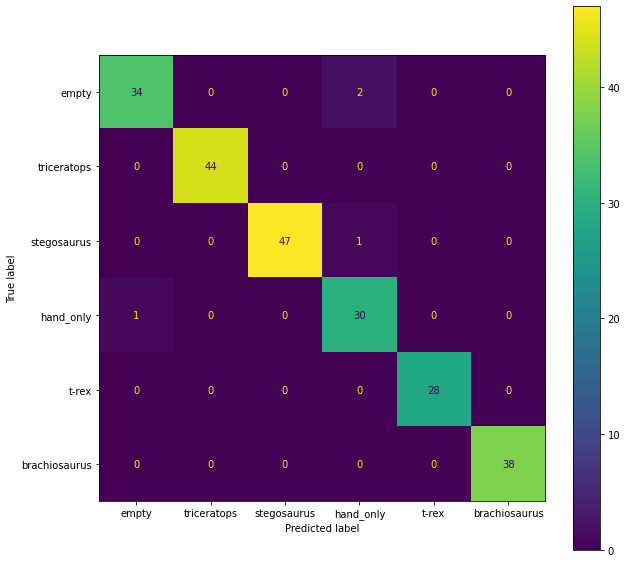

In [38]:
# Plot confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=classes)#np.unique(np.argmax(y_test, axis=1)))
fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax);

## Save best model

In [39]:
# Save the model (note '_' behind model if build_fn method is used) - note: keras model, not scikeras!
scikeras_cnn.model_.save('../imageclassifier/models/scikeras_cnn')

INFO:tensorflow:Assets written to: scikeras_cnn/assets


In [40]:
# Check folder structure
%ls scikeras_cnn/

assets/            keras_metadata.pb  saved_model.pb     variables/


In [41]:
# Model can be reloaded via...
# cnn_classifier = models.load_model("scikeras_cnn")

# Use a pretrained CNN

## Define preprocessing

In [35]:
preprocessor = preprocessing.image.ImageDataGenerator(
    # preprocessing function - will be directly coupled with model
    preprocessing_function=mobilenet_v2.preprocess_input,
    # fill_mode='nearest',
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # horizontal_flip=True, 
    # zoom_range=0.2,
    # shear_range=0.2    
    # dtype='uint8'
)

In [36]:
preprocessing_layer = keras.layers.Lambda(mobilenet_v2.preprocess_input, name="preprocessing")

In [37]:
augmentation = preprocessing.image.ImageDataGenerator(
    # augmentation of images, will only be used for training
    fill_mode='nearest',
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True, 
    zoom_range=0.2,
    shear_range=0.2    
)

## Create the model

In [38]:
# Use convolutional layers from mobile net as base model
base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet', 
    alpha=0.35,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # <------ !!!!! we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

In [39]:
# freeze base model, i.e. convolutional layers, won't be trained
base_model.trainable = False

In [40]:
# Check base model (trained parameters should be 0!)
base_model.summary()

Model: "mobilenetv2_0.35_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 48)   0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 48)   0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 48)  432         ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 48)  192         ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 144)  3456        ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 144)  576        ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 144)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 144)  1296       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 144)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 32)   4608        ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 32)  128         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 192)  6144        ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 336)   3024        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 336)   1344        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 336)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 56)     18816       ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [41]:
# Use base model and add new dense layers at the end
cnn_pretrained = keras.Sequential()
cnn_pretrained.add(base_model)
cnn_pretrained.add(keras.layers.Dense(100, activation='relu'))
cnn_pretrained.add(keras.layers.Dropout(0.5))
cnn_pretrained.add(keras.layers.Dense(len(classes), activation='softmax')) #!!! Final layer with a length of 2, and softmax activation 

# have a look at the trainable and non-trainable params statistic
cnn_pretrained.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_0.35_224 (Funct  (None, 1280)             410208    
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 100)               128100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 538,914
Trainable params: 128,706
Non-trainable params: 410,208
_________________________________________________________________


In [42]:
# Integrate preprocessing into the model
inputs = keras.Input(shape=(224, 224, 3))
x = preprocessing_layer(inputs)
outputs = cnn_pretrained(x)

cnn_pretrained_full = keras.Model(inputs, outputs)

In [43]:
# Compile the model
cnn_pretrained_full.compile(optimizer='Adam',
                            loss=keras.losses.categorical_crossentropy,
                            metrics=[keras.metrics.categorical_accuracy])

In [44]:
# Look at the model (note: preprocessing layer has no parameters to train/fit)
cnn_pretrained_full.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 preprocessing (Lambda)      (None, 224, 224, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 6)                 538914    
                                                                 
Total params: 538,914
Trainable params: 128,706
Non-trainable params: 410,208
_________________________________________________________________


In [45]:
# Fit the model

# Observe the validation loss and stop when it does not improve after 3 iterations
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Split X_train data into training and validation data (since we implement live augmentation on val-data)
X_train_t, X_train_v, y_train_t, y_train_v = train_test_split(X_train, y_train, test_size=0.2)

# Do the actual fitting process
batch_size=50
cnn_pretrained_full.fit(
    augmentation.flow(X_train_t, y_train_t, batch_size=batch_size), # Makes realtime augmentation
    validation_data=(X_train_v, y_train_v),
    steps_per_epoch=len(X_train_t) // batch_size, # Should ensure that all pictures are used in one epoche
    epochs=50, 
    verbose=1, 
    callbacks=[early_stop])

Epoch 1/50
11/11 [==============================] - 5s 355ms/step - loss: 0.8332 - categorical_accuracy: 0.7053 - val_loss: 0.0587 - val_categorical_accuracy: 1.0000
Epoch 2/50
11/11 [==============================] - 3s 287ms/step - loss: 0.1519 - categorical_accuracy: 0.9544 - val_loss: 0.0099 - val_categorical_accuracy: 1.0000
Epoch 3/50
11/11 [==============================] - 3s 276ms/step - loss: 0.0539 - categorical_accuracy: 0.9924 - val_loss: 0.0047 - val_categorical_accuracy: 1.0000
Epoch 4/50
11/11 [==============================] - 3s 263ms/step - loss: 0.0424 - categorical_accuracy: 0.9924 - val_loss: 0.0028 - val_categorical_accuracy: 1.0000
Epoch 5/50
11/11 [==============================] - 3s 266ms/step - loss: 0.0225 - categorical_accuracy: 0.9981 - val_loss: 0.0026 - val_categorical_accuracy: 1.0000
Epoch 6/50
11/11 [==============================] - 3s 266ms/step - loss: 0.0221 - categorical_accuracy: 0.9943 - val_loss: 0.0026 - val_categorical_accuracy: 1.0000
Epoc

## Evaluate final model

In [641]:
# Show score for train and test data
cnn_pretrained_full.evaluate(X_train, y_train), cnn_pretrained_full.evaluate(X_test, y_test)

6/6 [==============================] - 1s 195ms/step - loss: 0.0075 - categorical_accuracy: 0.9944


([0.003482137806713581, 1.0], [0.007484790403395891, 0.9944444894790649])

In [644]:
# Determine predictions for test data
y_pred = cnn_pretrained_full.predict(X_test)

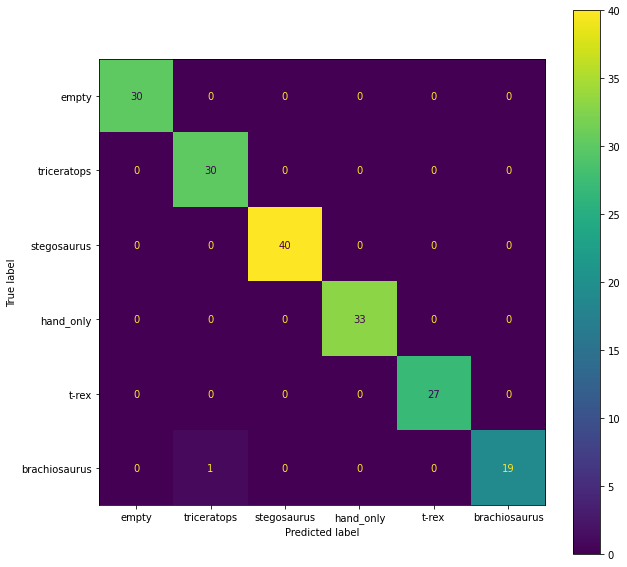

In [645]:
# Plot confusion matrix
cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=np.argmax(y_pred, axis=1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=classes)#np.unique(np.argmax(y_test, axis=1)))
fig, ax = plt.subplots(figsize=(10,10))

disp.plot(ax=ax);

## Save best model

In [647]:
# Save the model (note '_' behind model if build_fn method is used) - note: keras model, not scikeras!
cnn_pretrained_full.save('../imageclassifier/models/cnn_pretrained')

INFO:tensorflow:Assets written to: cnn_pretrained/assets


INFO:tensorflow:Assets written to: cnn_pretrained/assets


In [260]:
# Check folder structure
%ls cnn_pretrained/

assets/            keras_metadata.pb  saved_model.pb     variables/


In [41]:
# Model can be reloaded via...
# cnn_classifier = models.load_model("cnn_pretrained")